In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import DenseNet201
from keras.applications import DenseNet121

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [3]:
train_dir = 'data/bioimaging/train/'
test_dir = "data/bioimaging/test/"

extracted_features_dir = "extracted_features/"
model_name = "bioimaging_DenseNet121"

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.10.0
dim_ordering: tf


In [5]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/bioimaging/train/ 0
data/bioimaging/train/carcinoma 5696
data/bioimaging/train/non-carcinoma 5696
******************************
data/bioimaging/test/ 0
data/bioimaging/test/carcinoma 36
data/bioimaging/test/non-carcinoma 35


In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 8544 images belonging to 2 classes.
Found 2848 images belonging to 2 classes.
Found 71 images belonging to 2 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 8544
nb_validation_samples: 2848

predict_size_train: 267
predict_size_validation: 89
nb_test_samples: 71
predict_size_test: 3

 num_classes: 2


In [9]:
# from keras.backend.tensorflow_backend import get_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import set_session

# def reset_keras_tf_session():
#     """
#     this function clears the gpu memory and set the 
#     tf session to not use the whole gpu
#     """
#     sess = get_session()
#     clear_session()
#     sess.close()
#     sess = get_session()

# #     config = tf.ConfigProto()
# #     config.gpu_options.allow_growth = True
# #     set_session(tf.Session(config=config))


# reset_keras_tf_session()

In [10]:
# from keras.applications.mobilenetv2 import MobileNetV2
# from keras.applications.densenet import DenseNet169
# from keras.applications.vgg19 import VGG19
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.vgg16 import VGG16
# from keras.applications.xception import Xception, preprocess_input
# from keras.applications import DenseNet201
from keras.applications import DenseNet121
# from keras.applications import ResNet50
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
# from keras.applications import NASNetLarge, NASNetMobile
# from keras.applications import MobileNet


input_tensor = Input(shape = input_shape)  
model = DenseNet121(weights='imagenet', include_top=False, pooling = 'avg', input_tensor=input_tensor)
bottleneck_final_model = model

In [11]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [12]:
# c1 = model.layers[9].output 
# c1 = GlobalAveragePooling2D()(c1)       

# c2 = model.layers[55].output
# c2 = GlobalAveragePooling2D()(c2)       

# c3 = model.layers[143].output
# c3 = GlobalAveragePooling2D()(c3)       

# c4 = model.layers[483].output
# c4 = GlobalAveragePooling2D()(c4)

# con = concatenate([c1, c2, c3, c4])

# bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [13]:
# bottleneck_final_model.summary()

In [14]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [15]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [16]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [17]:
dropout_rate = 0.4

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.9, amsgrad=False)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 8544 samples, validate on 2848 samples
Epoch 1/1000
 - 2s - loss: 0.5304 - acc: 0.7341 - val_loss: 0.3392 - val_acc: 0.8718
Epoch 2/1000
 - 1s - loss: 0.3346 - acc: 0.8603 - val_loss: 0.2797 - val_acc: 0.8880
Epoch 3/1000
 - 1s - loss: 0.2699 - acc: 0.8908 - val_loss: 0.2107 - val_acc: 0.9319
Epoch 4/1000
 - 1s - loss: 0.2172 - acc: 0.9211 - val_loss: 0.1719 - val_acc: 0.9473
Epoch 5/1000
 - 1s - loss: 0.1832 - acc: 0.9326 - val_loss: 0.1531 - val_acc: 0.9501
Epoch 6/1000
 - 1s - loss: 0.1548 - acc: 0.9486 - val_loss: 0.1280 - val_acc: 0.9593
Epoch 7/1000
 - 1s - loss: 0.1325 - acc: 0.9556 - val_loss: 0.1079 - val_acc: 0.9712
Epoch 8/1000
 - 1s - loss: 0.1122 - acc: 0.9644 - val_loss: 0.1068 - val_acc: 0.9642
Epoch 9/1000
 - 1s - loss: 0.0986 - acc: 0.9686 - val_loss: 0.0805 - val_acc: 0.9814
Epoch 10/1000
 - 1s - loss: 0.0853 - acc: 0.9728 - val_loss: 0.0726 - val_acc: 0.9828
Epoch 11/1000
 - 1s - loss: 0.0731 - acc: 0.9798 - val_loss: 0.0625 - val_acc: 0.9863
Epoch 12/1000
 

Epoch 95/1000
 - 1s - loss: 1.6663e-04 - acc: 1.0000 - val_loss: 0.0055 - val_acc: 0.9972
Epoch 96/1000
 - 1s - loss: 2.2102e-04 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9982
Epoch 97/1000
 - 1s - loss: 1.7601e-04 - acc: 1.0000 - val_loss: 0.0058 - val_acc: 0.9979
Epoch 98/1000
 - 1s - loss: 4.5072e-04 - acc: 0.9999 - val_loss: 0.0050 - val_acc: 0.9979
Epoch 99/1000
 - 1s - loss: 1.5354e-04 - acc: 1.0000 - val_loss: 0.0056 - val_acc: 0.9979
Epoch 100/1000
 - 1s - loss: 4.4958e-04 - acc: 0.9999 - val_loss: 0.0045 - val_acc: 0.9986
Epoch 101/1000
 - 1s - loss: 1.6414e-04 - acc: 1.0000 - val_loss: 0.0046 - val_acc: 0.9986
Epoch 102/1000
 - 1s - loss: 1.5212e-04 - acc: 1.0000 - val_loss: 0.0052 - val_acc: 0.9986
Epoch 103/1000
 - 1s - loss: 3.0840e-04 - acc: 0.9999 - val_loss: 0.0052 - val_acc: 0.9975
Epoch 104/1000
 - 1s - loss: 1.7420e-04 - acc: 1.0000 - val_loss: 0.0056 - val_acc: 0.9972
Epoch 105/1000
 - 1s - loss: 1.4274e-04 - acc: 1.0000 - val_loss: 0.0065 - val_acc: 0.9986
Epoc

 - 1s - loss: 1.0504e-05 - acc: 1.0000 - val_loss: 0.0058 - val_acc: 0.9982
Epoch 186/1000
 - 1s - loss: 1.2008e-05 - acc: 1.0000 - val_loss: 0.0050 - val_acc: 0.9982
Epoch 187/1000
 - 1s - loss: 2.3183e-05 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 0.9986
Epoch 188/1000
 - 1s - loss: 1.4120e-05 - acc: 1.0000 - val_loss: 0.0044 - val_acc: 0.9982
Epoch 189/1000
 - 1s - loss: 7.4695e-06 - acc: 1.0000 - val_loss: 0.0065 - val_acc: 0.9986
Epoch 190/1000
 - 1s - loss: 8.3225e-06 - acc: 1.0000 - val_loss: 0.0072 - val_acc: 0.9982
Epoch 191/1000
 - 1s - loss: 4.0300e-05 - acc: 1.0000 - val_loss: 0.0055 - val_acc: 0.9975
Epoch 192/1000
 - 1s - loss: 3.9754e-06 - acc: 1.0000 - val_loss: 0.0051 - val_acc: 0.9982
Epoch 193/1000
 - 1s - loss: 1.3393e-05 - acc: 1.0000 - val_loss: 0.0056 - val_acc: 0.9982
Epoch 194/1000
 - 1s - loss: 2.2269e-05 - acc: 1.0000 - val_loss: 0.0052 - val_acc: 0.9989
Epoch 195/1000
 - 1s - loss: 4.9105e-06 - acc: 1.0000 - val_loss: 0.0079 - val_acc: 0.9986
Epoch 196/1000

Epoch 276/1000
 - 1s - loss: 9.2152e-06 - acc: 1.0000 - val_loss: 0.0054 - val_acc: 0.9982
Epoch 277/1000
 - 1s - loss: 5.4112e-07 - acc: 1.0000 - val_loss: 0.0053 - val_acc: 0.9989
Epoch 278/1000
 - 1s - loss: 1.2745e-06 - acc: 1.0000 - val_loss: 0.0050 - val_acc: 0.9986
Epoch 279/1000
 - 1s - loss: 3.3525e-07 - acc: 1.0000 - val_loss: 0.0063 - val_acc: 0.9986
Epoch 280/1000
 - 1s - loss: 6.8177e-07 - acc: 1.0000 - val_loss: 0.0051 - val_acc: 0.9986
Epoch 281/1000
 - 1s - loss: 1.9518e-06 - acc: 1.0000 - val_loss: 0.0056 - val_acc: 0.9986
Epoch 282/1000
 - 1s - loss: 1.4640e-06 - acc: 1.0000 - val_loss: 0.0052 - val_acc: 0.9982
Epoch 283/1000
 - 1s - loss: 1.3492e-06 - acc: 1.0000 - val_loss: 0.0058 - val_acc: 0.9982
Epoch 284/1000
 - 1s - loss: 5.7970e-06 - acc: 1.0000 - val_loss: 0.0052 - val_acc: 0.9982
Epoch 285/1000
 - 1s - loss: 6.2359e-06 - acc: 1.0000 - val_loss: 0.0049 - val_acc: 0.9989
Epoch 286/1000
 - 1s - loss: 4.6150e-06 - acc: 1.0000 - val_loss: 0.0055 - val_acc: 0.9986

 - 1s - loss: 6.1521e-07 - acc: 1.0000 - val_loss: 0.0062 - val_acc: 0.9986
Epoch 367/1000
 - 1s - loss: 7.8241e-07 - acc: 1.0000 - val_loss: 0.0050 - val_acc: 0.9989
Epoch 368/1000
 - 1s - loss: 2.8157e-07 - acc: 1.0000 - val_loss: 0.0051 - val_acc: 0.9989
Epoch 369/1000
 - 1s - loss: 5.2880e-07 - acc: 1.0000 - val_loss: 0.0055 - val_acc: 0.9986
Epoch 370/1000
 - 1s - loss: 3.1397e-07 - acc: 1.0000 - val_loss: 0.0053 - val_acc: 0.9982
Epoch 371/1000
 - 1s - loss: 2.9386e-06 - acc: 1.0000 - val_loss: 0.0055 - val_acc: 0.9982
Epoch 372/1000
 - 1s - loss: 2.4141e-07 - acc: 1.0000 - val_loss: 0.0055 - val_acc: 0.9989
Epoch 373/1000
 - 1s - loss: 1.7758e-07 - acc: 1.0000 - val_loss: 0.0054 - val_acc: 0.9982
Epoch 374/1000
 - 1s - loss: 4.2550e-07 - acc: 1.0000 - val_loss: 0.0063 - val_acc: 0.9986
Epoch 375/1000
 - 1s - loss: 2.0916e-07 - acc: 1.0000 - val_loss: 0.0057 - val_acc: 0.9986
Epoch 376/1000
 - 1s - loss: 3.6050e-06 - acc: 1.0000 - val_loss: 0.0057 - val_acc: 0.9986
Epoch 377/1000

Epoch 457/1000
 - 1s - loss: 4.5428e-07 - acc: 1.0000 - val_loss: 0.0054 - val_acc: 0.9986
Epoch 458/1000
 - 1s - loss: 9.0274e-07 - acc: 1.0000 - val_loss: 0.0056 - val_acc: 0.9986
Epoch 459/1000
 - 1s - loss: 2.4407e-05 - acc: 1.0000 - val_loss: 0.0060 - val_acc: 0.9982
Epoch 460/1000
 - 1s - loss: 2.2759e-06 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9989
Epoch 461/1000
 - 1s - loss: 8.5434e-07 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 0.9989
Epoch 462/1000
 - 1s - loss: 1.6547e-07 - acc: 1.0000 - val_loss: 0.0050 - val_acc: 0.9989
Epoch 463/1000
 - 1s - loss: 1.0192e-06 - acc: 1.0000 - val_loss: 0.0053 - val_acc: 0.9993
Epoch 464/1000
 - 1s - loss: 1.8707e-07 - acc: 1.0000 - val_loss: 0.0056 - val_acc: 0.9986
Epoch 465/1000
 - 1s - loss: 1.6797e-07 - acc: 1.0000 - val_loss: 0.0040 - val_acc: 0.9993
Epoch 466/1000
 - 1s - loss: 9.7377e-07 - acc: 1.0000 - val_loss: 0.0046 - val_acc: 0.9989
Epoch 467/1000
 - 1s - loss: 1.5155e-07 - acc: 1.0000 - val_loss: 0.0050 - val_acc: 0.9986

 - 1s - loss: 1.3809e-07 - acc: 1.0000 - val_loss: 0.0052 - val_acc: 0.9986
Epoch 548/1000
 - 1s - loss: 1.3329e-07 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 0.9986
Epoch 549/1000
 - 1s - loss: 1.2885e-07 - acc: 1.0000 - val_loss: 0.0053 - val_acc: 0.9986
Epoch 550/1000
 - 1s - loss: 5.8247e-07 - acc: 1.0000 - val_loss: 0.0050 - val_acc: 0.9989
Epoch 551/1000
 - 1s - loss: 2.0508e-07 - acc: 1.0000 - val_loss: 0.0054 - val_acc: 0.9989
Epoch 552/1000
 - 1s - loss: 1.9487e-07 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 0.9993
Epoch 553/1000
 - 1s - loss: 6.3289e-05 - acc: 1.0000 - val_loss: 0.0055 - val_acc: 0.9989
Epoch 554/1000
 - 1s - loss: 2.4480e-07 - acc: 1.0000 - val_loss: 0.0052 - val_acc: 0.9993
Epoch 555/1000
 - 1s - loss: 1.7954e-07 - acc: 1.0000 - val_loss: 0.0057 - val_acc: 0.9986
Epoch 556/1000
 - 1s - loss: 6.7282e-07 - acc: 1.0000 - val_loss: 0.0058 - val_acc: 0.9986
Epoch 557/1000
 - 1s - loss: 7.7420e-07 - acc: 1.0000 - val_loss: 0.0057 - val_acc: 0.9986
Epoch 558/1000

Epoch 638/1000
 - 1s - loss: 1.7389e-07 - acc: 1.0000 - val_loss: 0.0060 - val_acc: 0.9986
Epoch 639/1000
 - 1s - loss: 2.1666e-07 - acc: 1.0000 - val_loss: 0.0060 - val_acc: 0.9986
Epoch 640/1000
 - 1s - loss: 1.7136e-06 - acc: 1.0000 - val_loss: 0.0072 - val_acc: 0.9986
Epoch 641/1000
 - 1s - loss: 1.5035e-07 - acc: 1.0000 - val_loss: 0.0072 - val_acc: 0.9982
Epoch 642/1000
 - 1s - loss: 2.0313e-07 - acc: 1.0000 - val_loss: 0.0050 - val_acc: 0.9989
Epoch 643/1000
 - 1s - loss: 1.3325e-07 - acc: 1.0000 - val_loss: 0.0058 - val_acc: 0.9986
Epoch 644/1000
 - 1s - loss: 1.7174e-07 - acc: 1.0000 - val_loss: 0.0051 - val_acc: 0.9993
Epoch 645/1000
 - 1s - loss: 2.3830e-07 - acc: 1.0000 - val_loss: 0.0051 - val_acc: 0.9993
Epoch 646/1000
 - 1s - loss: 1.4914e-07 - acc: 1.0000 - val_loss: 0.0061 - val_acc: 0.9986
Epoch 647/1000
 - 1s - loss: 1.6064e-07 - acc: 1.0000 - val_loss: 0.0060 - val_acc: 0.9986
Epoch 648/1000
 - 1s - loss: 1.4080e-07 - acc: 1.0000 - val_loss: 0.0064 - val_acc: 0.9986

 - 1s - loss: 3.0636e-06 - acc: 1.0000 - val_loss: 0.0060 - val_acc: 0.9986
Epoch 729/1000
 - 1s - loss: 1.3438e-07 - acc: 1.0000 - val_loss: 0.0063 - val_acc: 0.9986
Epoch 730/1000
 - 1s - loss: 5.9858e-07 - acc: 1.0000 - val_loss: 0.0066 - val_acc: 0.9986
Epoch 731/1000
 - 1s - loss: 2.5048e-07 - acc: 1.0000 - val_loss: 0.0056 - val_acc: 0.9989
Epoch 732/1000
 - 1s - loss: 1.4107e-07 - acc: 1.0000 - val_loss: 0.0059 - val_acc: 0.9986
Epoch 733/1000
 - 1s - loss: 1.4866e-07 - acc: 1.0000 - val_loss: 0.0066 - val_acc: 0.9989
Epoch 734/1000
 - 1s - loss: 2.1517e-07 - acc: 1.0000 - val_loss: 0.0056 - val_acc: 0.9993
Epoch 735/1000
 - 1s - loss: 1.9532e-06 - acc: 1.0000 - val_loss: 0.0062 - val_acc: 0.9986
Epoch 736/1000
 - 1s - loss: 1.6201e-07 - acc: 1.0000 - val_loss: 0.0054 - val_acc: 0.9989
Epoch 737/1000
 - 1s - loss: 1.7144e-07 - acc: 1.0000 - val_loss: 0.0059 - val_acc: 0.9989
Epoch 738/1000
 - 1s - loss: 1.4273e-07 - acc: 1.0000 - val_loss: 0.0054 - val_acc: 0.9989
Epoch 739/1000

Epoch 819/1000
 - 1s - loss: 2.0921e-07 - acc: 1.0000 - val_loss: 0.0057 - val_acc: 0.9989
Epoch 820/1000
 - 1s - loss: 2.6851e-07 - acc: 1.0000 - val_loss: 0.0065 - val_acc: 0.9986
Epoch 821/1000
 - 1s - loss: 1.3825e-07 - acc: 1.0000 - val_loss: 0.0073 - val_acc: 0.9986
Epoch 822/1000
 - 1s - loss: 1.2404e-07 - acc: 1.0000 - val_loss: 0.0061 - val_acc: 0.9993
Epoch 823/1000
 - 1s - loss: 1.3352e-07 - acc: 1.0000 - val_loss: 0.0060 - val_acc: 0.9989
Epoch 824/1000
 - 1s - loss: 5.0472e-07 - acc: 1.0000 - val_loss: 0.0080 - val_acc: 0.9982
Epoch 825/1000
 - 1s - loss: 1.6324e-07 - acc: 1.0000 - val_loss: 0.0065 - val_acc: 0.9989
Epoch 826/1000
 - 1s - loss: 4.3150e-07 - acc: 1.0000 - val_loss: 0.0065 - val_acc: 0.9989
Epoch 827/1000
 - 1s - loss: 1.2436e-07 - acc: 1.0000 - val_loss: 0.0067 - val_acc: 0.9989
Epoch 828/1000
 - 1s - loss: 4.5006e-06 - acc: 1.0000 - val_loss: 0.0064 - val_acc: 0.9989
Epoch 829/1000
 - 1s - loss: 3.0810e-07 - acc: 1.0000 - val_loss: 0.0068 - val_acc: 0.9989

 - 1s - loss: 5.2037e-07 - acc: 1.0000 - val_loss: 0.0066 - val_acc: 0.9989
Epoch 910/1000
 - 1s - loss: 2.5785e-07 - acc: 1.0000 - val_loss: 0.0061 - val_acc: 0.9986
Epoch 911/1000
 - 1s - loss: 1.2810e-07 - acc: 1.0000 - val_loss: 0.0058 - val_acc: 0.9993
Epoch 912/1000
 - 1s - loss: 1.2489e-07 - acc: 1.0000 - val_loss: 0.0078 - val_acc: 0.9982
Epoch 913/1000
 - 1s - loss: 4.4768e-07 - acc: 1.0000 - val_loss: 0.0080 - val_acc: 0.9982
Epoch 914/1000
 - 1s - loss: 2.0440e-06 - acc: 1.0000 - val_loss: 0.0061 - val_acc: 0.9986
Epoch 915/1000
 - 1s - loss: 1.6259e-06 - acc: 1.0000 - val_loss: 0.0064 - val_acc: 0.9989
Epoch 916/1000
 - 1s - loss: 1.2436e-07 - acc: 1.0000 - val_loss: 0.0063 - val_acc: 0.9986
Epoch 917/1000
 - 1s - loss: 1.4836e-07 - acc: 1.0000 - val_loss: 0.0062 - val_acc: 0.9986
Epoch 918/1000
 - 1s - loss: 1.9125e-07 - acc: 1.0000 - val_loss: 0.0062 - val_acc: 0.9989
Epoch 919/1000
 - 1s - loss: 1.5639e-07 - acc: 1.0000 - val_loss: 0.0059 - val_acc: 0.9989
Epoch 920/1000

Epoch 1000/1000
 - 1s - loss: 1.2146e-07 - acc: 1.0000 - val_loss: 0.0060 - val_acc: 0.9993


In [18]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.8309859154929577


Confusion Matrix
[[32  4]
 [ 8 27]]


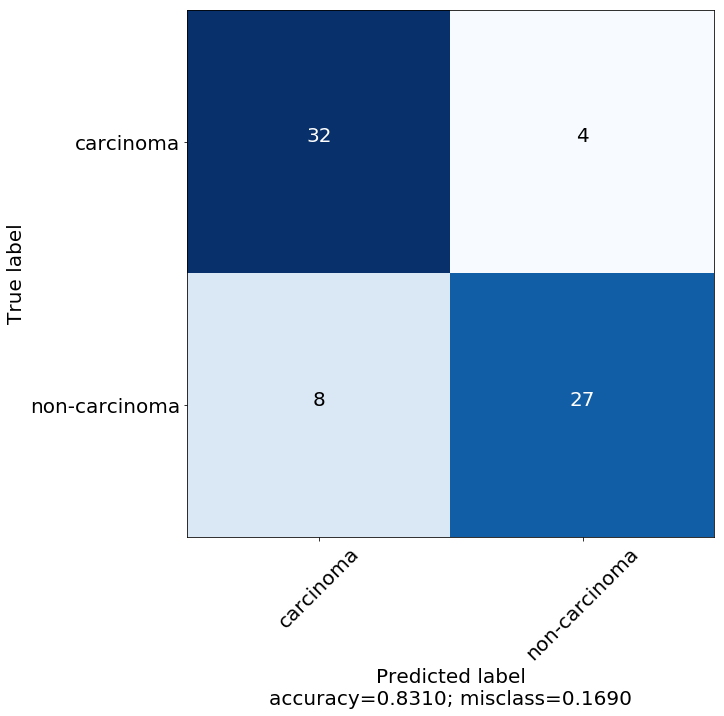

In [19]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[32  4]
 [ 8 27]]
               precision    recall  f1-score   support

    carcinoma       0.80      0.89      0.84        36
non-carcinoma       0.87      0.77      0.82        35

  avg / total       0.83      0.83      0.83        71



In [21]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  80.0
Specificity :  87.09677419354838


In [22]:
print('roc_auc_score = ' + str(roc_auc_score(predictions, y_true)))

roc_auc_score = 0.8354838709677421


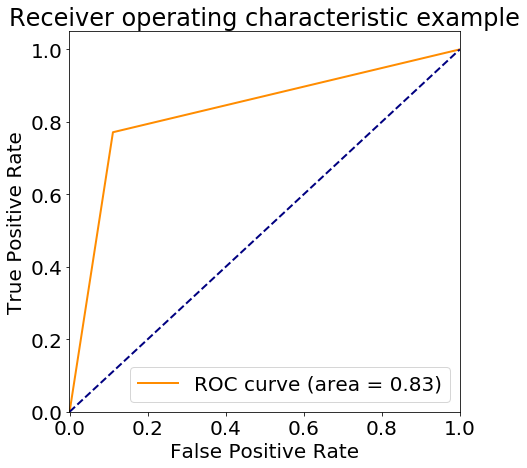

In [23]:
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [24]:
predict = model.predict_proba(test_data, batch_size=batch_size, verbose=1)

71/71 [==============================] - 0s 0us/step


In [25]:
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [26]:
from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

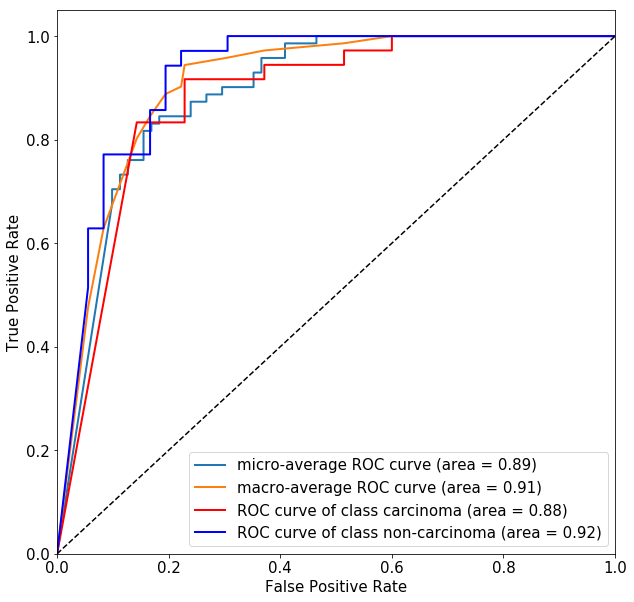

In [27]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [28]:
tn, fp, fn, tp = cm.ravel()

In [29]:
print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("Precision:",(tp/(tp+fp)))
print("Recall:",(tp/(tp+fn)))
print("tp:", tp) 
print("fp:", fp) 
print("tn:",tn) 
print("fn:",fn)

Accuracy: 0.8309859154929577
Precision: 0.8709677419354839
Recall: 0.7714285714285715
tp: 27
fp: 4
tn: 32
fn: 8


In [30]:
print('F1 score:', f1_score(y_true, y_pred))

F1 score: 0.8181818181818182


In [31]:
recall = (tp/(tp+fn))
precision=(tp/(tp+fp))

f1 = 2 / ( (1/recall) + (1 / precision))
print('F1 score:', f1)

F1 score: 0.8181818181818181


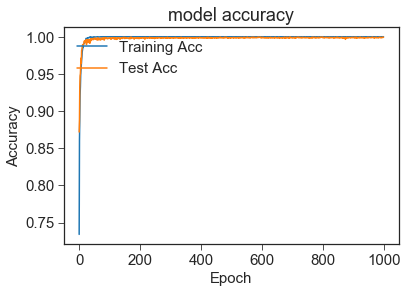

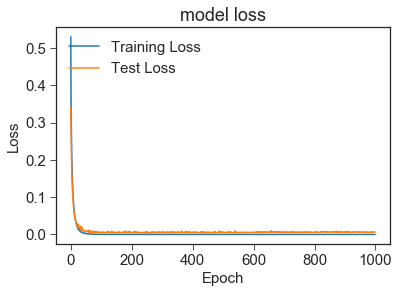

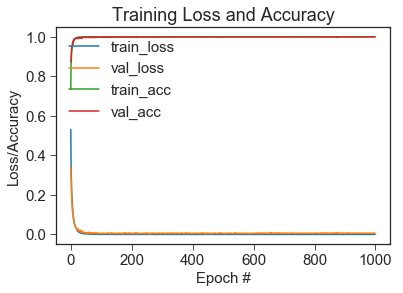

In [32]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")